# 1. Defining a simple Neural Net for Linear Regression

Our goal on this notebook is to model and fit a simple neural net to solve the linear regression problem,
i.e., given `n` points on $\mathbb{R}^{2}$, we need to find the best fit slope and intercept of the 
line that represent those points.

For that, I am going to use the ``keras`` library, since it is one of the most intuitives libraries to work
with Neural Nets.

Without further due, let's get started by importing some standards Python libraries and building
our neural net class wrapping around ``Keras`` functionalities.

In [1]:
from tqdm import tqdm

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense

class LinearRegressionNN(object):
    """This class is a simple wrapper around Keras' API which
    is used to implement a Neural Net to perform linear regression.
    """
    
    def __init__(self):
        # We only need one unit in our neural net. Why?
        # That's because one unit contains the exact number of parameters
        # to solve our problem: one weight (i.e. the slope) and
        # one bias (i.e. the intercept).
        # The activation function must be linear in order to build a model for a line.
        # I chose kernel_initializer='zeros' because we don't have prior information
        # on the slope of the "true". If we know, e.g., that the slopes are all positives
        # we could use that information by passing a different initializer, 'ones', for example.
        self.model = Sequential([Dense(units=1, activation='linear',
                                  input_shape=(1,), kernel_initializer='zeros')])
        # The mean squared error is perhaps the most classical loss function to
        # optimize for, so let's go for it. We could also use 'mae' if we know that
        # the dataset contains outliers.
        # Additionally, I'm going to choose a high learning rate here since
        # the optimization problem is fairly simple.
        opt = keras.optimizers.SGD(lr=1.)
        self.model.compile(loss='mse', optimizer='sgd', metrics=['mse'])
        # To save training time, let's use a callback to stop training as soon
        # as our loss function doesn't decrease by more than 1e-4
        self.callbacks = [EarlyStopping(monitor='loss', min_delta=1e-4)]
    
    def fit(self, x, y, epochs=10000, **kwargs):
        """
        Arguments
        ---------
        x : array
            x-coordinate measurements
        y : array
            y-coordinate measurements
        epochs : int
            Number of epochs to run the neural net.
        
        Returns
        -------
        (slope, intercept) : tuple of floats
            The "best" slope and intercept.
        """
        self.model.fit(x=x, y=y, epochs=epochs, callbacks=self.callbacks, **kwargs)
        return (self.model.get_weights()[0][0][0], self.model.get_weights()[1][0])

Using TensorFlow backend.


# 2. Testing the Neural Net on a toy dataset

Let's train our neural net model on a simple dataset just to make sure our ``LinearRegressionNN``
class does not contain any silly bugs.

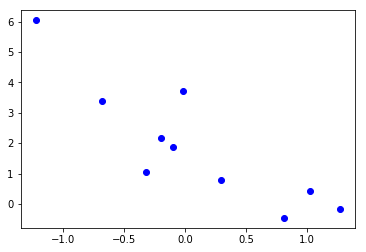

In [4]:
m, b = -3, 2

x = np.random.normal(size=10)
noise = np.random.normal(scale=1, size=10)
y = m * x + b + noise
plt.plot(x, y, 'bo')

In [5]:
linear_nn = LinearRegressionNN()

In [6]:
m_pred, b_pred = linear_nn.fit(x, y, verbose=0)

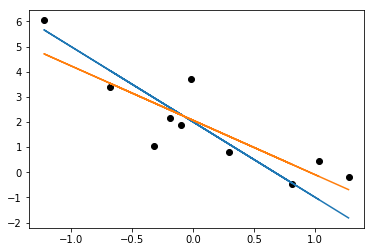

In [7]:
plt.plot(x, y, 'ko')
plt.plot(x, m * x + b)
plt.plot(x, m_pred * x + b_pred)

Looks good!

# 3. Results on the interview dataset

In [9]:
df = pd.read_csv("train_100k/train_100k.csv")

In [10]:
df.head()

,id,x0,y0,x1,y1,x2,y2,x3,y3,x4,...,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9
0,0,29.379006,-177.906597,66.239362,-143.495070,-107.178287,-338.177166,22.166375,-185.843612,84.694131,...,136.901770,-81.681363,-84.118333,-334.626033,-100.681489,-336.766765,-37.043301,-253.037134,0.695548,-211.044600
1,1,-42.192600,116.207765,81.428046,-94.915600,-68.070200,154.431135,87.454642,-119.361432,-86.614036,...,-40.894683,123.924804,111.751223,-139.521058,15.587590,-0.594559,-19.313860,70.677833,-53.806709,133.994773
2,2,-18.796404,329.114854,151.712130,-447.480672,-110.947150,798.737732,105.217794,-173.445516,-55.966933,...,-15.222389,428.073085,250.005691,-768.685467,-2.994061,253.920340,-40.446864,413.669479,-66.874356,487.322412
3,3,-6.481551,226.761616,-185.217750,737.531205,9.613335,186.972940,-106.689135,490.035371,-151.022795,...,-4.505889,258.659858,-89.331309,489.818816,-8.596002,289.845448,192.360821,-315.923385,154.112777,-189.089460
4,4,31.330370,217.733186,-118.727553,308.958404,115.202328,127.442284,-8.540804,235.844732,-19.587220,...,-53.328056,267.077917,84.485304,175.295198,-76.208199,273.898265,45.614982,203.163031,-22.831323,251.840567


Let's define two functions to normalize the dataset and to transform the fitted parameters from the normalized space to the original space. Normalization of the inputs will considerably
aid the optimization, since the initial values of the slope and intercept, in the neural net, are both zero. But we have
to be careful to transform back the fitted slope and intercept to the original data space.

Let's write a bit of math for completeness. The expression of a line is:

$$ y = m \cdot x + b$$

After normalizing the inputs, it follows that:

$$ \dfrac{y - \bar{y}}{\sigma_{y}} = m \cdot \dfrac{x - \bar{x}}{\sigma_x} + b,$$
where $\bar{x}, \bar{y}$, $\sigma_x$, and $\sigma_y$ are the means and standard deviations
of $x$ and $y$.

We could rewrite the above expression as:

$$ y = x\cdot \left( m \dfrac{\sigma_y}{\sigma_x}\right) + \left(\dfrac{m\cdot \bar{x}}{\sigma_x} + \sigma_y b +  \bar{y}\right)$$

Therefore, the slope and the intercept on the original data space are given as:
$$ \mathrm{slope} =  m \dfrac{\sigma_y}{\sigma_x}$$
$$ \mathrm{intercept} = \dfrac{m\cdot \bar{x}}{\sigma_x} + \sigma_y b +  \bar{y}$$

In [46]:
def normalize(x, y):
    mean_x, mean_y = np.mean(x), np.mean(y)
    std_x, std_y = np.std(x), np.std(y)
    return (x - mean_x)/std_x, (y - mean_y)/std_y, mean_x, mean_y, std_x, std_y
def inverse_normalize(m, b, mean_x, mean_y, std_x, std_y):
    return m * std_y / std_x, mean_y - m * mean_x * std_y / std_x + std_y * b

Now, let's loop over the interview's dataset, in which in each iteration we
normalize the current data row, fit the neural net, transform the fitted weights
onto the original data space, and save them in lists.

In [12]:
slope_pred = []
intercept_pred = []
for i in tqdm(range(len(df))):
    df_row = df[df.id == i]
    x, y = [], []
    for col in df.columns:
        if col.startswith('x'):
            x.append(float(df_row[col]))
        if col.startswith('y'):
            y.append(float(df_row[col]))
    x = np.asarray(x)
    y = np.asarray(y)
    xnorm, ynorm, mean_x, mean_y, std_x, std_y = normalize(x, y)
    m, b = linear_nn.fit(xnorm, ynorm, verbose=0)
    m_pred, b_pred = inverse_normalize(m, b, mean_x, mean_y, std_x, std_y)
    slope_pred.append(m_pred)
    intercept_pred.append(b_pred)

100%|██████████| 100000/100000 [3:39:41<00:00,  7.59it/s] 


In [40]:
from collections import OrderedDict

In [41]:
pred_dict = OrderedDict({'id': list(range(0, len(df))), 'slope': slope_pred, 'intercept': intercept_pred})

In [42]:
pred_df = pd.DataFrame.from_dict(pred_dict)

In [43]:
pred_df.to_csv('pred.csv', index=False)

Running the ``evaluate.py`` script to evaluate our neural net performance, ``python evaluate.py train_100k.truth.csv pred.csv``, we get the following results:

$$ \text{Slope mse}: 0.0128555678847, ~~\text{Intercept mae}: 4.24232329667 $$